# High Resolution Conflict Forecasting with Spatial Convolutions and Long Short-Term Memory

## Replication Archive

[Benjamin J. Radford](https://www.benradford.com)    
Assistant Professor  
UNC Charlotte  
bradfor7@uncc.edu  

This file replicates the following tables and figures:

* Table 2 (columns 5-8)

## Imports and seeds

In [1]:
#### import sys
import os
import gc
import logging

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from itertools import product
from math import isnan

import views
from views import Period, Model, Downsampling
from views.utils.data import assign_into_df
from views.apps.transforms import lib as translib
from views.apps.evaluation import lib as evallib, feature_importance as fi
from views.apps.model import api
from views.apps.extras import extras

import keras
from keras.models import Model
from keras.layers import Input, ConvLSTM2D, Activation, Conv3D, BatchNormalization, Dropout, Bidirectional, GaussianNoise
from keras import optimizers

import tensorflow as tf

import random
import geoplot as gplt
import contextily as ctx

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

from numpy.random import seed
seed(1234)
tf.random.set_seed(1234)

pgid_groupa = [149426,149427,149428,149429,149430, 148706,148707,148708,148709,148710, 147986,
147987,147988,147989,147990, 147266,147267,147268,147269,147270, 146546,146547,146548,
146549,146550]

pgid_groupb = [114918,114919,114920,114921,114922, 114198,114199,114200,114201,114202, 113478,
113479,113480,113481,113482, 112758,112759,112760,112761,112762, 112038,112039,112040,
112041,112042]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
df = pd.read_csv("../data/t1_pgm.csv")

In [4]:
def get_row_metrics(actual,pred,rowname):
    mse = np.mean(np.power(actual - pred,2))
    tadda = evallib.tadda_score(actual, pred)
    return f"{rowname} & {mse:.3f} & {tadda:.3f} \\\\"

print("\hline \n \\\\ Steps & MSE & TADDA \\\\ \n \hline \\\\")
# print(get_row_metrics(df.loc[(df["month_id"]==)]["delta_1"], 
#                       df.loc[(df["month_id"]==)]["Radford_clstm_s1"],
#                       "$s=1$"))
print(get_row_metrics(df.loc[(df["month_id"]==490)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==490)]["radford"],
                      "$s=2$"))
print(get_row_metrics(df.loc[(df["month_id"]==491)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==491)]["radford"],
                      "$s=3$"))
print(get_row_metrics(df.loc[(df["month_id"]==492)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==492)]["radford"],
                      "$s=4$"))
print(get_row_metrics(df.loc[(df["month_id"]==493)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==493)]["radford"],
                      "$s=5$"))
print(get_row_metrics(df.loc[(df["month_id"]==494)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==494)]["radford"],
                      "$s=6$"))
print(get_row_metrics(df.loc[(df["month_id"]==495)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==495)]["radford"],
                      "$s=7$"))
print("\hline")


print("\hline \n \\\\ Steps & MSE & TADDA \\\\ \n \hline \\\\")
# print(get_row_metrics(df.loc[(df["month_id"]==)]["delta_1"], 
#                       df.loc[(df["month_id"]==)]["Radford_clstm_s1"],
#                       "$s=1$"))
print(get_row_metrics(df.loc[(df["month_id"]==490)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==490)]["benchmark"],
                      "$s=2$"))
print(get_row_metrics(df.loc[(df["month_id"]==491)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==491)]["benchmark"],
                      "$s=3$"))
print(get_row_metrics(df.loc[(df["month_id"]==492)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==492)]["benchmark"],
                      "$s=4$"))
print(get_row_metrics(df.loc[(df["month_id"]==493)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==493)]["benchmark"],
                      "$s=5$"))
print(get_row_metrics(df.loc[(df["month_id"]==494)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==494)]["benchmark"],
                      "$s=6$"))
print(get_row_metrics(df.loc[(df["month_id"]==495)]["d_ln_ged_best_sb"], 
                      df.loc[(df["month_id"]==495)]["benchmark"],
                      "$s=7$"))
print("\hline")

\hline 
 \\ Steps & MSE & TADDA \\ 
 \hline \\
$s=2$ & 0.024 & 0.018 \\
$s=3$ & 0.028 & 0.019 \\
$s=4$ & 0.025 & 0.020 \\
$s=5$ & 0.036 & 0.024 \\
$s=6$ & 0.036 & 0.021 \\
$s=7$ & 0.035 & 0.025 \\
\hline
\hline 
 \\ Steps & MSE & TADDA \\ 
 \hline \\
$s=2$ & 0.053 & 0.138 \\
$s=3$ & 0.059 & 0.142 \\
$s=4$ & 0.052 & 0.142 \\
$s=5$ & 0.064 & 0.150 \\
$s=6$ & 0.063 & 0.148 \\
$s=7$ & 0.064 & 0.153 \\
\hline


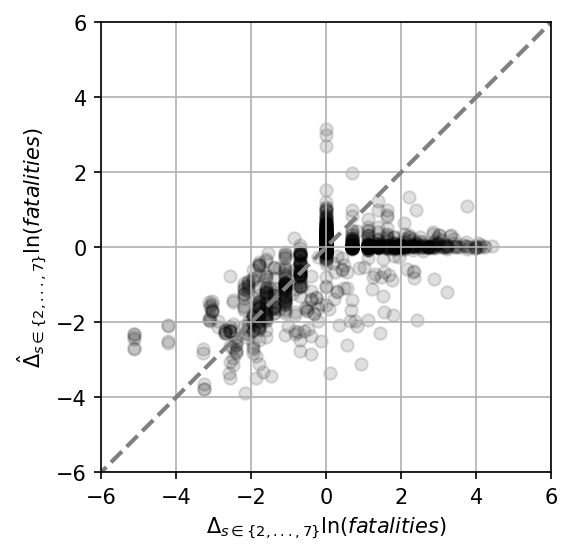

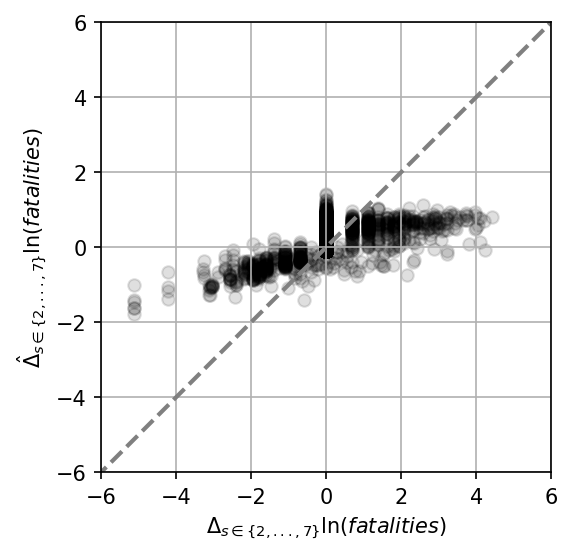

In [5]:
fig=plt.figure(figsize=(3,3),dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df["d_ln_ged_best_sb"],df["radford"], color='#00000020')
ax.plot([-100, 100], [-100, 100], color="gray", linestyle='--', linewidth=2)
ax.set_xlabel('$\Delta_{s \in \{2,...,7\}}\ln(fatalities)$')
ax.set_ylabel('$\hat{\Delta}_{s \in \{2,...,7\}}\ln(fatalities)$')
# ax.set_title('Actual Versus Predicted Change')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.grid(True)
plt.savefig("../figures/task1_radford_actual_vs_predicted.pdf", bbox_inches='tight')
plt.show()

fig=plt.figure(figsize=(3,3),dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df["d_ln_ged_best_sb"],df["benchmark"], color='#00000020')
ax.plot([-100, 100], [-100, 100], color="gray", linestyle='--', linewidth=2)
ax.set_xlabel('$\Delta_{s \in \{2,...,7\}}\ln(fatalities)$')
ax.set_ylabel('$\hat{\Delta}_{s \in \{2,...,7\}}\ln(fatalities)$')
# ax.set_title('Actual Versus Predicted Change')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.grid(True)
plt.savefig("../figures/task1_benchmark_actual_vs_predicted.pdf", bbox_inches='tight')
plt.show()

# from matplotlib.colors import Normalize 
# from scipy.interpolate import interpn
# from matplotlib import cm

# def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
#     """
#     Scatter plot colored by 2d histogram
#     """
#     if ax is None :
#         fig , ax = plt.subplots()
#     data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
#     z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

#     #To be sure to plot all data
#     z[np.where(np.isnan(z))] = 0.0

#     # Sort the points by density, so that the densest points are plotted last
#     if sort :
#         idx = z.argsort()
#         x, y, z = x[idx], y[idx], z[idx]

#     ax.scatter( x, y, c=z, **kwargs )
#     ax.plot([-100, 100], [-100, 100], color="gray", linestyle='--', linewidth=2)
    
#     plt.xlim(-6,6)
#     plt.ylim(-6,6)
#     plt.grid(True)

#     norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#     cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
#     cbar.ax.set_ylabel('Density')

#     return ax

# density_scatter(df["d_ln_ged_best_sb"], df["radford"])
# density_scatter(df["d_ln_ged_best_sb"], df["benchmark"])